## Task 1

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from data.cf_loader import Task1Loader, Task2Loader

/home/nas4_user/hawonjeong/anaconda3/envs/won/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "3"
torch.cuda.is_available()

True

In [48]:
task1_dataset = Task1Loader('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/user_itemset_training.csv').data_preprocess()
valid_df = pd.read_csv('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/user_itemset_valid_query.csv', names=['user_id', 'itemset_id'])
valid_ans = pd.read_csv('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/user_itemset_valid_answer.csv', names=['answer'])
print("Loading data is done.")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53897/53897 [00:32<00:00, 1645.72it/s]


Loading data is done.


In [49]:
NUM_USERS = 53897
NUM_ITEMSETS = 27694
latent_dim = 4096

In [50]:
user_rep = torch.zeros((NUM_USERS, latent_dim))

for user in tqdm(range(NUM_USERS)):
    checkpoint_path = f'/home/nas4_user/saemeechoi/course/DataMining/WCL/data/dataset/features_task1/{user}.pt'
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    user_rep[user] = checkpoint

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53897/53897 [03:27<00:00, 259.50it/s]


In [51]:
mul_user_rep = torch.mm(user_rep, user_rep.t())

norm = torch.sqrt(torch.diag(mul_user_rep)).unsqueeze(1)
user_sim = torch.div(mul_user_rep, norm)
user_sim = torch.div(user_sim, norm.t())
user_sim[torch.eye(user_sim.size(0)).bool()] = 0

In [59]:
task1_dataset_tensor = torch.tensor(task1_dataset).float()
valid_df['score'] = torch.zeros(len(valid_df))

# if torch.cuda.is_available():
#     user_sim = user_sim.to('cuda')
#     task1_dataset_tensor = task1_dataset_tensor.to('cuda')

for i in tqdm(range(len(valid_df))):
    user_id = valid_df['user_id'][i]
    itemset_id = valid_df['itemset_id'][i]

    numer = torch.matmul(user_sim[user_id].unsqueeze(0), task1_dataset_tensor[:, itemset_id].unsqueeze(1))
    denom = torch.sum(user_sim[user_id])

    valid_df['score'][i] = numer.item() / denom.item()

  0%|                                                                                                                                                                                                     | 0/335940 [00:00<?, ?it/s]/tmp/ipykernel_2418547/2927134531.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['score'][i] = numer.item() / denom.item() * 100.0
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335940/335940 [14:59<00:00, 373.67it/s]


#### ▼▼▼ Evaluation on validation set

In [11]:
from sklearn.metrics import accuracy_score

y_score = np.array(valid_df['score'])
y_true = np.array(valid_ans['answer'])

thresholds = np.linspace(0, 0.005, num=100)

accuracy_values = []
max_acc = 0
max_threshold = 0

for threshold in thresholds:
    # Convert scores to binary labels based on threshold
    y_pred = [1 if score >= threshold else 0 for score in y_score]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    if accuracy > max_acc:
        max_acc = accuracy
        max_threshold = threshold

    # Append metric values to lists
    accuracy_values.append(accuracy)

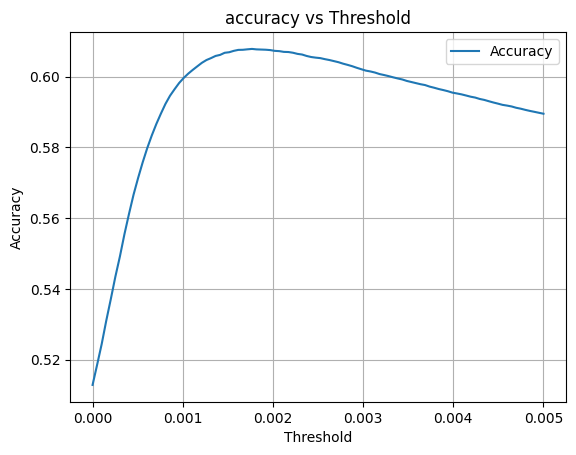

In [12]:
import matplotlib.pyplot as plt

plt.plot(thresholds, accuracy_values, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# task 1
print(max_acc)
print(max_threshold)

0.6078525927248913
0.0017676767676767678


#### ▼▼▼ Run code on test set

In [74]:
test_df = pd.read_csv('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/user_itemset_test_query.csv', names=['user_id', 'itemset_id'])
test_df['score'] = torch.zeros(len(test_df))

In [75]:
for i in tqdm(range(len(test_df))):
    wcl_id = test_df[test_df.columns[0]][i]
    weight_id = test_df[test_df.columns[1]][i]

    numer = torch.matmul(user_sim[wcl_id].unsqueeze(0), task1_dataset_tensor[:, weight_id].unsqueeze(1))
    denom = torch.sum(user_sim[wcl_id])

    test_df['score'][i] = numer.item() / denom.item()

  0%|                                                                                                                                                                                                     | 0/335940 [00:00<?, ?it/s]/tmp/ipykernel_2418547/415710219.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['score'][i] = numer.item() / denom.item()
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335940/335940 [09:35<00:00, 583.54it/s]


In [85]:
test_df['prediction'] = 0
for i in tqdm(range(len(test_df))):
    test_df['prediction'][i] = 1 if test_df['score'][i] >= threshold else 0

  0%|                                                                                                                                                                                                     | 0/335940 [00:00<?, ?it/s]/tmp/ipykernel_2418547/2015786856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'][i] = 1 if test_df['score'][i] >= threshold else 0
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335940/335940 [00:53<00:00, 6256.00it/s]


In [87]:
test_df = test_df.drop(['user_id', 'itemset_id', 'score'], axis=1)

In [92]:
test_df.to_csv('/home/nas4_user/hawonjeong/courses/ai506/DM_termproj/results/user_itemset_test_prediction.csv', index=False)

## Task 2

In [19]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from data.cf_loader import Task1Loader, Task2Loader

In [20]:
os.environ["CUDA_VISIBLE_DEVICES"]= "3"
torch.cuda.is_available()

True

In [21]:
task2_dataset = Task2Loader('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/itemset_item_training.csv').data_preprocess()
task2_valid_dataset = Task2Loader('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/itemset_item_valid_query.csv').data_preprocess()
valid_df = pd.read_csv('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/itemset_item_valid_query.csv', names=['itemset_id', 'item_id'])
valid_ans = pd.read_csv('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/itemset_item_valid_answer.csv', names=['itemset_id', 'item_id'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2769/2769 [00:00<00:00, 5970.70it/s]


In [22]:
NUM_USERS = 53897
NUM_ITEMSETS = 27694
latent_dim = 4096
NUM_ITEMS = 42653

In [23]:
wcl_rep = torch.zeros((NUM_ITEMSETS, latent_dim))

for itemset in tqdm(range(NUM_ITEMSETS)):
    checkpoint_path = f'/home/nas4_user/saemeechoi/course/DataMining/WCL/data/dataset/features_task2_2/{itemset}.pt'
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    wcl_rep[itemset] = checkpoint
print("Checkpoints are loaded.")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27694/27694 [05:07<00:00, 90.10it/s]

Checkpoints are loaded.


In [24]:
# Get similarity matrix
mul_wcl_rep = torch.mm(wcl_rep, wcl_rep.t())
norm = torch.sqrt(torch.diag(mul_wcl_rep)).unsqueeze(1)
sim = torch.div(mul_wcl_rep, norm)
sim = torch.div(sim, norm.t())
sim[torch.eye(sim.size(0)).bool()] = 0

In [25]:
# >>>>> To get multi-hot representation of all items
# 1. Training set
df = pd.read_csv('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/itemset_item_training.csv', names=['itemset_id', 'item_id'])
itemsets = list(set(df['itemset_id'].tolist()))

data_dict = dict()
for itemset in tqdm(itemsets):
    items = df[df['itemset_id']==itemset]['item_id'].tolist()
    data_dict.update({itemset:items})

itemset_item = np.zeros((NUM_ITEMSETS, NUM_ITEMS))    
for i, (k, v) in enumerate(data_dict.items()) :
    itemset_item[k, v] = 1

# 2. Valid set
df = pd.read_csv('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/itemset_item_valid_query.csv', names=['itemset_id', 'item_id'])
itemsets = list(set(df['itemset_id'].tolist()))

data_dict = dict()
for itemset in tqdm(itemsets):
    items = df[df['itemset_id']==itemset]['item_id'].tolist()
    data_dict.update({itemset:items})

for i, (k, v) in enumerate(data_dict.items()) :
    itemset_item[k,v] = 1

# 3. Test set
df = pd.read_csv('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/itemset_item_test_query.csv', names=['itemset_id', 'item_id'])
itemsets = list(set(df['itemset_id'].tolist()))

data_dict = dict()
for itemset in tqdm(itemsets):
    items = df[df['itemset_id']==itemset]['item_id'].tolist()
    data_dict.update({itemset:items})

for i, (k, v) in enumerate(data_dict.items()) :
    itemset_item[k,v] = 1

9# <<<<< End of getting multi-hot representation of all items
print(itemset_item.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2769/2769 [00:00<00:00, 5826.92it/s]

(27694, 42653)


In [38]:
itemset_item_tensor = torch.tensor(itemset_item).float()

In [39]:
# valid_ans['candidate_items'][i] = [item1_score, item2_score, ..., item100_score]
valid_ans['candidate_items'] = None

for i in tqdm(range(len(valid_ans))):
    itemset_id = valid_ans[valid_ans.columns[0]][i]
    
    # get scores of all items
    numer = torch.matmul(sim[itemset_id].unsqueeze(0), itemset_item_tensor)
    denom = torch.sum(sim[itemset_id])
    item_scores = numer.squeeze() / denom.item()
    
    top_100_items = torch.argsort(item_scores, descending=True)[:100]
    valid_ans['candidate_items'][i] = top_100_items.cpu().numpy()

  0%|                                                                                                                                                                                                       | 0/2769 [00:00<?, ?it/s]/tmp/ipykernel_2418547/1561788337.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ans['candidate_items'][i] = top_100_items.cpu().numpy()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2769/2769 [08:11<00:00,  5.64it/s]


In [40]:
valid_ans

,itemset_id,item_id,candidate_items
0,6998,14100,"[31432, 34338, 25194, 13979, 19204, 27447, 737..."
1,8941,37713,"[31432, 34338, 25194, 19204, 13979, 27447, 129..."
2,11717,29703,"[31432, 27447, 13979, 25194, 34338, 19204, 364..."
3,18595,37718,"[31432, 34338, 25194, 13979, 27447, 19204, 129..."
4,23064,42559,"[34338, 31432, 25194, 19204, 13979, 16926, 274..."
...,...,...,...
2764,396,11105,"[25194, 19204, 16926, 13979, 27447, 31432, 364..."
2765,7525,35558,"[34338, 31432, 25194, 19204, 13979, 4191, 2895..."
2766,14719,24249,"[31432, 34338, 25194, 13979, 19204, 27447, 169..."
2767,23768,10764,"[31432, 34338, 25194, 13979, 19204, 27447, 737..."


#### ▼▼▼ Evaluation on validation set

In [41]:
# task 2 accuracy
from sklearn.metrics import accuracy_score

y_pred = [0 for i in range(len(valid_ans))]
y_pred_rank = [101 for i in range(len(valid_ans))]

for idx in range(len(valid_ans['itemset_id'])):
    
    item_id = valid_ans['item_id'][idx]
    candidate_items = valid_ans['candidate_items'][idx]
    
    if np.isin(item_id, candidate_items):
        y_pred_rank[idx] = np.where(candidate_items == item_id)[0].item()
        y_pred[idx] = 1
        
# accuracy
# y_true = list(valid_ans['item_id'])
accuracy = sum(y_pred) / len(valid_ans)
average_rank = np.mean(y_pred_rank)

In [42]:
print("Accuracy: ", accuracy)20
print("Average rank: ", average_rank)

Accuracy:  0.12026002166847237
Average rank:  93.18237630913687


#### ▼▼▼ Run code on test set

In [93]:
test_df = pd.read_csv('/home/nas3_userL/sohyunjeong/work_dir/etc/23spring/hw2/dataset/itemset_item_test_query.csv', names=['itemset_id', 'item_id'])

In [94]:
# itemset_item: caculated at validation
itemset_item_tensor = torch.tensor(itemset_item).float()

# if torch.cuda.is_available():
#     sim = sim.to('cuda')
#     itemset_item_tensor = itemset_item_tensor.to('cuda')

In [95]:
test_df['candidate_items'] = None

for i in tqdm(range(len(test_df))):
    itemset_id = test_df[test_df.columns[0]][i]

    # get scores of all items
    numer = torch.matmul(sim[itemset_id].unsqueeze(0), itemset_item_tensor)
    denom = torch.sum(sim[itemset_id])
    item_scores = numer.squeeze() / denom.item()

    top_100_items = torch.argsort(item_scores, descending=True)[:100]
    test_df['candidate_items'][i] = top_100_items.cpu().numpy()

  0%|                                                                                                                                                                                                       | 0/7759 [00:00<?, ?it/s]/tmp/ipykernel_2418547/1037155184.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['candidate_items'][i] = top_100_items.cpu().numpy()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7759/7759 [25:02<00:00,  5.16it/s]


In [98]:
# For submission
test_sub = test_df.copy()
test_sub = test_sub.drop("item_id", axis = 1)

print(test_sub)

      itemset_id                                    candidate_items
0          22934  [31432, 34338, 25194, 19204, 13979, 7377, 2744...
1          22934  [31432, 34338, 25194, 19204, 13979, 7377, 2744...
2          22934  [31432, 34338, 25194, 19204, 13979, 7377, 2744...
3          26086  [31432, 34338, 25194, 13979, 27447, 12942, 192...
4          26086  [31432, 34338, 25194, 13979, 27447, 12942, 192...
...          ...                                                ...
7754       19505  [34338, 31432, 25194, 19204, 13979, 27447, 737...
7755       20370  [34338, 31432, 25194, 7377, 19204, 12942, 1397...
7756       20370  [34338, 31432, 25194, 7377, 19204, 12942, 1397...
7757        7148  [34338, 31432, 19204, 25194, 13979, 27447, 737...
7758        7148  [34338, 31432, 19204, 25194, 13979, 27447, 737...

[7759 rows x 2 columns]


In [101]:
columns = ['itemset_id'] + ['item{}'.format(i) for i in range(1, 101)]

data = {}

data['itemset_id'] = test_sub['itemset_id']

for i, item_col in enumerate(test_sub['candidate_items'].apply(pd.Series).columns, start=1):
    data['item{}'.format(i)] = test_sub['candidate_items'].apply(pd.Series)[item_col]

new_df = pd.DataFrame(data, columns=columns)

In [102]:
new_df

,itemset_id,item1,item2,item3,item4,item5,item6,item7,item8,item9,...,item91,item92,item93,item94,item95,item96,item97,item98,item99,item100
0,22934,31432,34338,25194,19204,13979,7377,27447,12942,34643,...,27761,40884,33008,35072,2568,23968,33642,35358,19802,16039
1,22934,31432,34338,25194,19204,13979,7377,27447,12942,34643,...,27761,40884,33008,35072,2568,23968,33642,35358,19802,16039
2,22934,31432,34338,25194,19204,13979,7377,27447,12942,34643,...,27761,40884,33008,35072,2568,23968,33642,35358,19802,16039
3,26086,31432,34338,25194,13979,27447,12942,19204,28955,7377,...,34759,25186,39609,27761,37209,41526,8007,21114,2592,4986
4,26086,31432,34338,25194,13979,27447,12942,19204,28955,7377,...,34759,25186,39609,27761,37209,41526,8007,21114,2592,4986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7754,19505,34338,31432,25194,19204,13979,27447,7377,4191,28955,...,39475,23867,41526,21000,32842,37752,35006,31128,24947,16039
7755,20370,34338,31432,25194,7377,19204,12942,13979,27447,706,...,12819,14084,17807,16039,37718,36413,26324,1363,7977,38939
7756,20370,34338,31432,25194,7377,19204,12942,13979,27447,706,...,12819,14084,17807,16039,37718,36413,26324,1363,7977,38939
7757,7148,34338,31432,19204,25194,13979,27447,7377,16926,12942,...,24332,33642,17807,33299,15430,2278,29197,21506,33837,15774


In [103]:
new_df.to_csv('/home/nas4_user/hawonjeong/courses/ai506/DM_termproj/results/itemset_item_test_prediction.csv', index=False)